# TUD IS sentiment analysis tool
This notebook can be used as a tool for  Sentiment Analysis of Tweets from Twitter with the Google Natural Language API about given keywords.
## Preparations

Installation of python requirements

In [19]:
!pip install searchtweets-v2 google-cloud-language==2.2.2

You should consider upgrading via the 'C:\Users\Lukas\.virtualenvs\tud-is-sentiment-eogrpOkI\Scripts\python.exe -m pip install --upgrade pip' command.


In [20]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from google.cloud import language
from google.auth import load_credentials_from_file
from searchtweets import ResultStream, gen_request_parameters, load_credentials


### Preparations Google NLP-API
To authenticate against the Google NLP-API an enviromentvariable `GOOGLE_APPLICATION_CREDENTIALS` pointing to a credentials file must be present in the executing environment.

In addition the `analyze_text`-function uses a basic caching mechanism to save on API-Calls and network time.

In [21]:
# Instantiates a client
nlp_client = language.LanguageServiceClient(credentials=load_credentials_from_file('./credentials/tud-is-sentiment.json')[0])


def analyze_text(text, scope='document'):
    document = language.Document(
        content=text, type_=language.Document.Type.PLAIN_TEXT)
    
    f = nlp_client.analyze_entity_sentiment if scope == 'entity' else nlp_client.analyze_sentiment

    analysis = f(request={'document': document})

    return analysis


### Preparations for Twitter-API
Tweets from twitter are fetched using the search-tweets library. To fetch tweets a `fetch-tweets`-function is defined that returns tweets for the query from a disk cache if possible.

[https://github.com/twitterdev/search-tweets-python/tree/v2](https://github.com/twitterdev/search-tweets-python/tree/v2)

In [22]:
twitter_credentials_filename = "./credentials/twitter-academic.yml"

search_args_all = load_credentials(
    filename=twitter_credentials_filename,
    yaml_key="search_all_tweets_v2"
)

search_args_recent = load_credentials(
    filename=twitter_credentials_filename,
    yaml_key="search_recent_tweets_v2"
)

cache_directory = 'cache'


def fetch_tweets(search_term, credentials=search_args_all, max_results=10000):
    query = "{} -is:retweet".format(search_term)

    cache_path = os.path.join('.', cache_directory, '{}.csv'.format(
        ''.join(l for l in query if l not in [' ', ':'])
    ))

    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    try:
        df = pd.read_csv(cache_path)

    except FileNotFoundError:
        tweet_fields = [
            'id',
            'created_at',
            'text',
            'lang',
            # 'entities',
            'geo',
            # 'public_metrics',
            'source'
        ]

        rs = ResultStream(
            request_parameters=gen_request_parameters(
                query,
                None,
                results_per_call=500,
                tweet_fields=','.join(tweet_fields)
            ),
            max_results=max_results,
            **credentials
        )

        df = pd.DataFrame(

            data=sum([page['data'] for page in rs.stream()], [])
        )

        df.to_csv(cache_path, index=False)

    df = df.convert_dtypes()
    df['created_at'] = pd.to_datetime(df['created_at'])

    return df


In [23]:
df = fetch_tweets('artificial intelligence')
df.head()

,id,text,created_at,lang,source,geo
0,1438397948283396101,"This tractor is hard at work, helping farms go...",2021-09-16 07:02:49+00:00,en,PostBeyond,<NA>
1,1438397892616622081,"But it’s calm under the waves, in the blue of ...",2021-09-16 07:02:36+00:00,en,Twitter for iPhone,<NA>
2,1438397795761901570,Hello! Maybe it will be interesting for you. ...,2021-09-16 07:02:13+00:00,en,Twitter Web App,<NA>
3,1438397775276826630,Advantages and Disadvantages of Artificial Int...,2021-09-16 07:02:08+00:00,en,bitsecurity01,<NA>
4,1438397705164754953,Nothing wrong when a song ends in the minor ke...,2021-09-16 07:01:51+00:00,en,Twitter for iPhone,<NA>


In [24]:
sentiment_df = df.groupby('lang').resample('H', on='created_at').agg({'text': '. '.join})

ds = []
for row in sentiment_df.text:
    try:
        ds.append(analyze_text(row).document_sentiment)
    except:
        ds.append(namedtuple('Sentiment', ['score', 'magnitude'])(0,0))

scores, magnitudes = zip(*[(s.score, s.magnitude) for s in ds])

sentiment_df['score'] = scores
sentiment_df['magnitude'] = magnitudes

sentiment_df.head()

text  \
lang created_at                                                                     
da   2021-09-16 02:00:00+00:00  Finland - Artificial Intelligence https://t.co...   
     2021-09-16 03:00:00+00:00                                                      
     2021-09-16 04:00:00+00:00  Artificial Intelligence for IAF’s enhanced air...   
de   2021-09-16 07:00:00+00:00  #KI, #MachineLearning und explorative Datenana...   
en   2021-09-16 02:00:00+00:00  @carfraction @Michigandolf @tradermike88 Yeah ...   

                                score  magnitude  
lang created_at                                   
da   2021-09-16 02:00:00+00:00    0.0        0.0  
     2021-09-16 03:00:00+00:00    0.0        0.0  
     2021-09-16 04:00:00+00:00    0.2        0.2  
de   2021-09-16 07:00:00+00:00    0.2        0.8  
en   2021-09-16 02:00:00+00:00    0.0        8.0

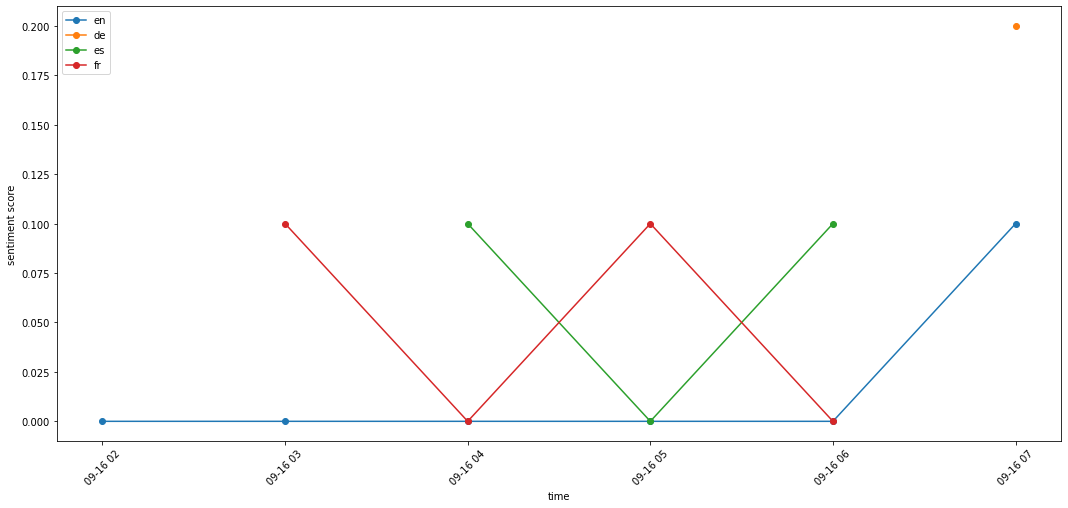

In [26]:
fig,ax = plt.subplots(figsize=(18, 8))

languages = sentiment_df.index.levels[0]
for lang in ['en', 'de', 'es', 'fr']:
    ax.plot(sentiment_df.loc[(lang)].score, 'o-', label=lang)
    #ax.plot(sentiment_df.loc[(lang)].magnitude, 'o--', label=lang)

ax.set_xlabel("time")
ax.set_ylabel("sentiment score")
ax.legend(loc='best')
plt.xticks(rotation=45)
plt.show()